In [1]:
from Utils.Data_Processing import *

import os

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
torch.set_default_dtype(STOCK_PRICE_DTYPE_TORCH)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

T_PAST = 60
T_FUT = 20
STEP_SZ = T_PAST//2

In [3]:
DATA_DIR = './Data'
STOCK_DATA_DIR = os.path.join(DATA_DIR, 'stocks')
WINDOW_DATA_DIR = os.path.join(DATA_DIR, f'windowed_data_{T_PAST}_{T_FUT}_{STEP_SZ}')
WINDOW_DT_DATA_DIR = os.path.join(DATA_DIR, f'windowed_dt_data_{T_PAST}_{T_FUT}_{STEP_SZ}')

TEST_STOCKS = {'NVDA', 'GM', 'LMT', 'HPQ', 'FWONK', 'MSI', 'ARM', 'MSFT', 'JNJ'}

In [4]:
train_tickers, test_tickers = [], []

for f_name in sorted(os.listdir(WINDOW_DATA_DIR)):
  stock_ticker = f_name.split('.')[0][:-len('_windows')]
  
  if stock_ticker in TEST_STOCKS:
    test_tickers.append(stock_ticker)
  else:
    train_tickers.append(stock_ticker)

# Pytorch Analysis

## MLP Model

In [5]:
TRAIN_BATCH_SZ = 128
TEST_BATCH_SZ = 512

In [7]:
train_ds = make_market_dataset(train_tickers, WINDOW_DATA_DIR, WINDOW_DT_DATA_DIR, T_PAST, T_FUT,
                               num_windows=1, scale=True)
train_dl = make_market_dataloader(train_ds, TRAIN_BATCH_SZ)

test_ds = make_market_dataset(test_tickers, WINDOW_DATA_DIR, WINDOW_DT_DATA_DIR, T_PAST, T_FUT,
                              num_windows=1, scale=True)
test_dl = make_market_dataloader(test_ds, TEST_BATCH_SZ)

In [8]:
# Build the neural network model
# Define the model architecture
model = nn.Sequential(
  nn.Flatten(1,2),
  nn.Linear(2*T_PAST, 200),
  nn.ReLU(),
  nn.Linear(200, 100),
  nn.ReLU(),
  nn.Linear(100, 100),
  nn.ReLU(),
  nn.Linear(100, 40),
  nn.ReLU(),
  nn.Linear(40, T_FUT)
)
model.to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())  # Adam optimizer

In [9]:
num_epochs = 10
train_losses, test_losses, train_maes, test_maes = [], [], [], []

# Evaluate the model
with torch.no_grad():
  te_loss, te_mae = 0.0, 0.0
  for std_past, _, dt_past, std_fut, _, dt_fut, _ in test_dl:
    X_test = torch.concat((std_past, dt_past), dim=2).to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)
    Y_test = std_fut.reshape((-1, T_FUT)).to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)
    
    model.half()
    test_outputs = model(X_test)

    te_loss += criterion(test_outputs, Y_test).item()
    te_mae = torch.mean(torch.abs(test_outputs - Y_test))
  test_losses.append(float(te_loss)/len(test_dl))
  test_maes.append(float(te_mae)/len(test_dl))
print('init test loss', round(test_losses[-1], 4))
print('init test MAE', round(test_maes[-1], 4))

# Train the model
for epoch in tqdm(range(num_epochs), total=num_epochs):
  optimizer.zero_grad()
  tr_loss, tr_mae = 0.0, 0.0
  for i, (std_past, _, dt_past, std_fut, _, dt_fut, _) in enumerate(train_dl):
    # print(i, 'pre: # NaN params', sum((int(torch.mean(torch.isnan(param).to(torch.float16)).item() > 0) for param in model.parameters())))
    X_train = torch.concat((std_past, dt_past), dim=2).to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)
    Y_train = std_fut.reshape((-1, T_FUT)).to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)
    
    model.half()
    train_outputs = model(X_train)  # Forward pass
    loss = criterion(train_outputs, Y_train)  # Calculate the loss
    
    # print('Y_hat', train_outputs.shape, torch.mean(torch.isnan(train_outputs).to(torch.float16)).item())
    loss.backward()  # Backward pass
    # print(i, 'bwd: # NaN params', sum((int(torch.mean(torch.isnan(param).to(torch.float16)).item() > 0) for param in model.parameters())))
    model.float()
    optimizer.step()  # Update weights
    # print(i, 'step: # NaN params', sum((int(torch.mean(torch.isnan(param).to(torch.float16)).item() > 0) for param in model.parameters())))
    
    optimizer.zero_grad()  # Zero the gradients
    tr_loss += loss.item()
    tr_mae = torch.mean(torch.abs(train_outputs - Y_train))
    # print('loss, mae', loss.item(), tr_mae.item())
    # if i == 1:
    #   raise NotImplementedError('UwU')
  
  # Evaluate the model
  with torch.no_grad():
    train_losses.append(float(tr_loss)/len(train_dl))
    train_maes.append(float(tr_mae)/len(train_dl))
    
    te_loss, te_mae = 0.0, 0.0
    for std_past, _, dt_past, std_fut, _, dt_fut, _ in test_dl:
      X_test = torch.concat((std_past, dt_past), dim=2).to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)
      Y_test = std_fut.reshape((-1, T_FUT)).to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)
      
      model.half()
      test_outputs = model(X_test)
  
      te_loss += criterion(test_outputs, Y_test).item()
      te_mae = torch.mean(torch.abs(test_outputs - Y_test))
    test_losses.append(float(te_loss)/len(test_dl))
    test_maes.append(float(te_mae)/len(test_dl))

init test loss 1.0475
init test MAE 0.2037


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


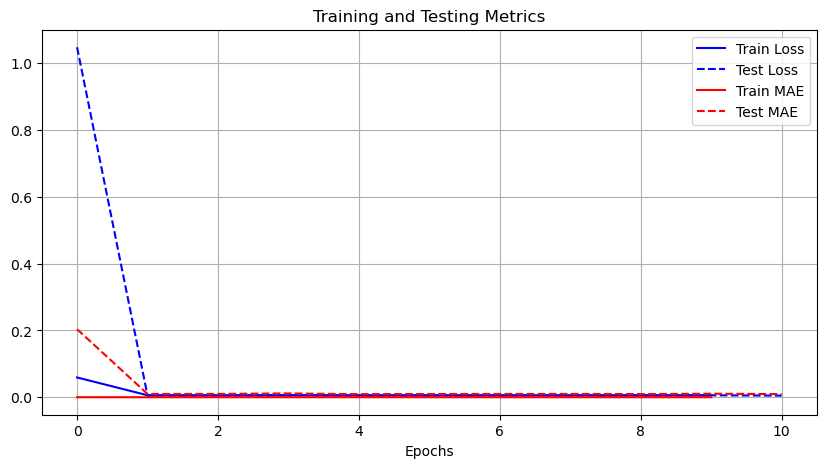

final train loss 0.006
final test loss 0.005


In [10]:
# Plot all metrics on one plot
plt.figure(figsize=(10, 5))

# Plot training and testing losses
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', linestyle='dashed', color='blue')

# Plot training and testing MAEs
plt.plot(train_maes, label='Train MAE', color='red')
plt.plot(test_maes, label='Test MAE', linestyle='dashed', color='red')

plt.xlabel('Epochs')
plt.title('Training and Testing Metrics')
plt.legend()
plt.grid(True)
plt.show()

print('final train loss', round(train_losses[-1], 4))
print('final test loss', round(test_losses[-1], 4))

In [ ]:
with torch.no_grad():
  std_past, scale_past, dt_past, std_fut, scale_fut, dt_fut, _ = next(iter(train_dl))
  
  X = torch.concat((std_past[:10], dt_past[:10]), dim=2).to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)
  Y = std_fut[:10].reshape((-1, T_FUT)).to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)
  Y_hat = model(X)
  
  torch.mean(torch.abs(Y-Y_hat))

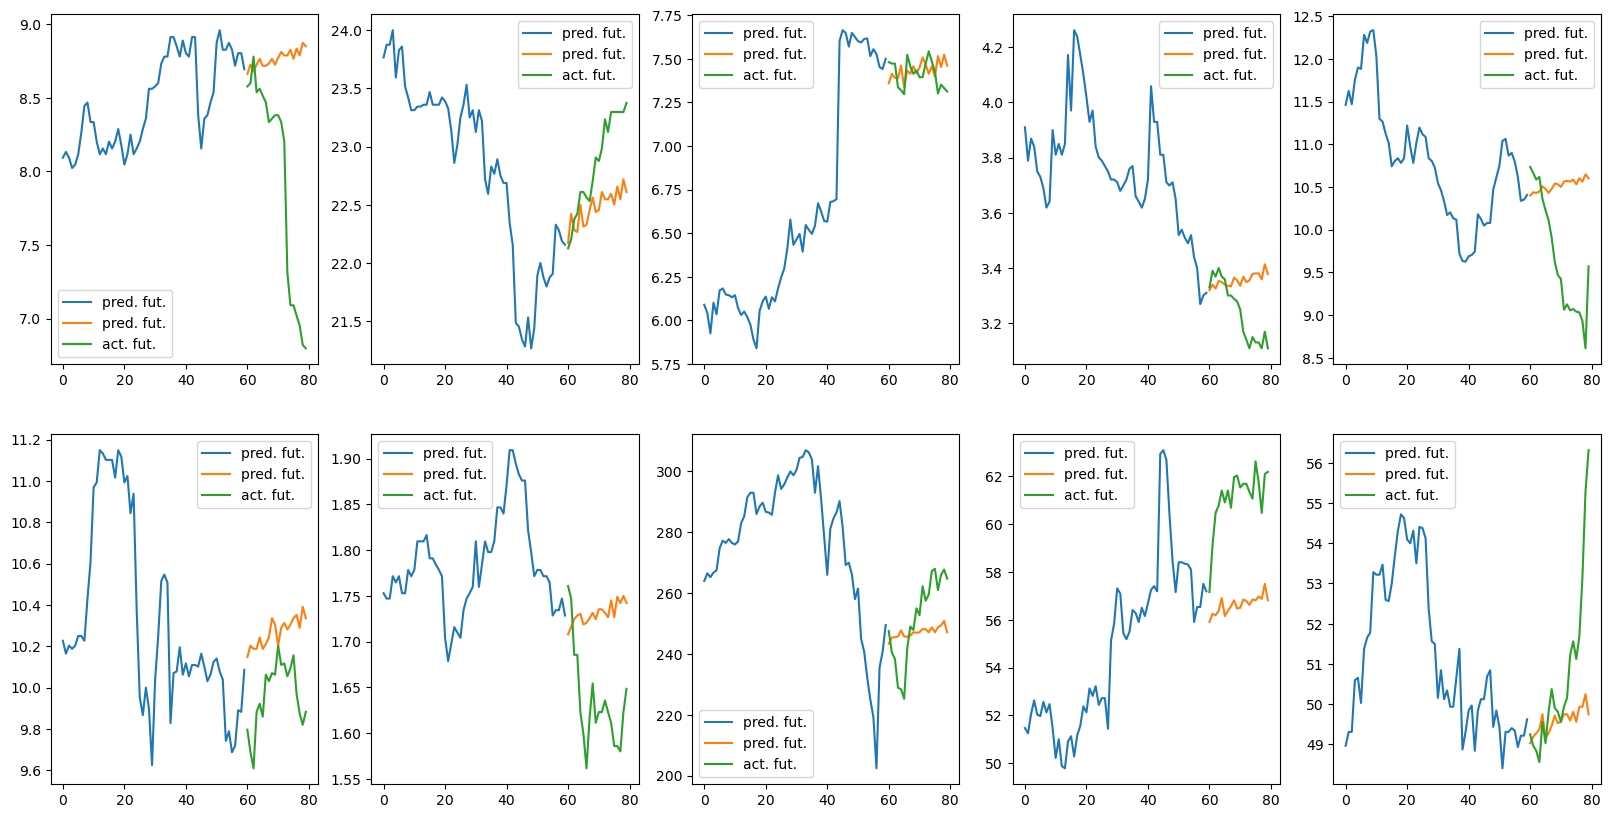

In [21]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i in range(10):
    ax[i//5, i%5].plot(range(T_PAST), std_past[i, 0, :]*scale_past.numpy()[i, 0, :], label='pred. fut.')
    ax[i//5, i%5].plot(range(T_PAST, T_PAST+T_FUT), Y_hat.cpu().numpy()[i, :]*scale_fut[i, 0, :].cpu().numpy(), label='pred. fut.')
    ax[i//5, i%5].plot(range(T_PAST, T_PAST+T_FUT), Y.cpu().numpy()[i, :]*scale_fut[i, 0, :].cpu().numpy(), label='act. fut.')
    ax[i//5, i%5].legend()

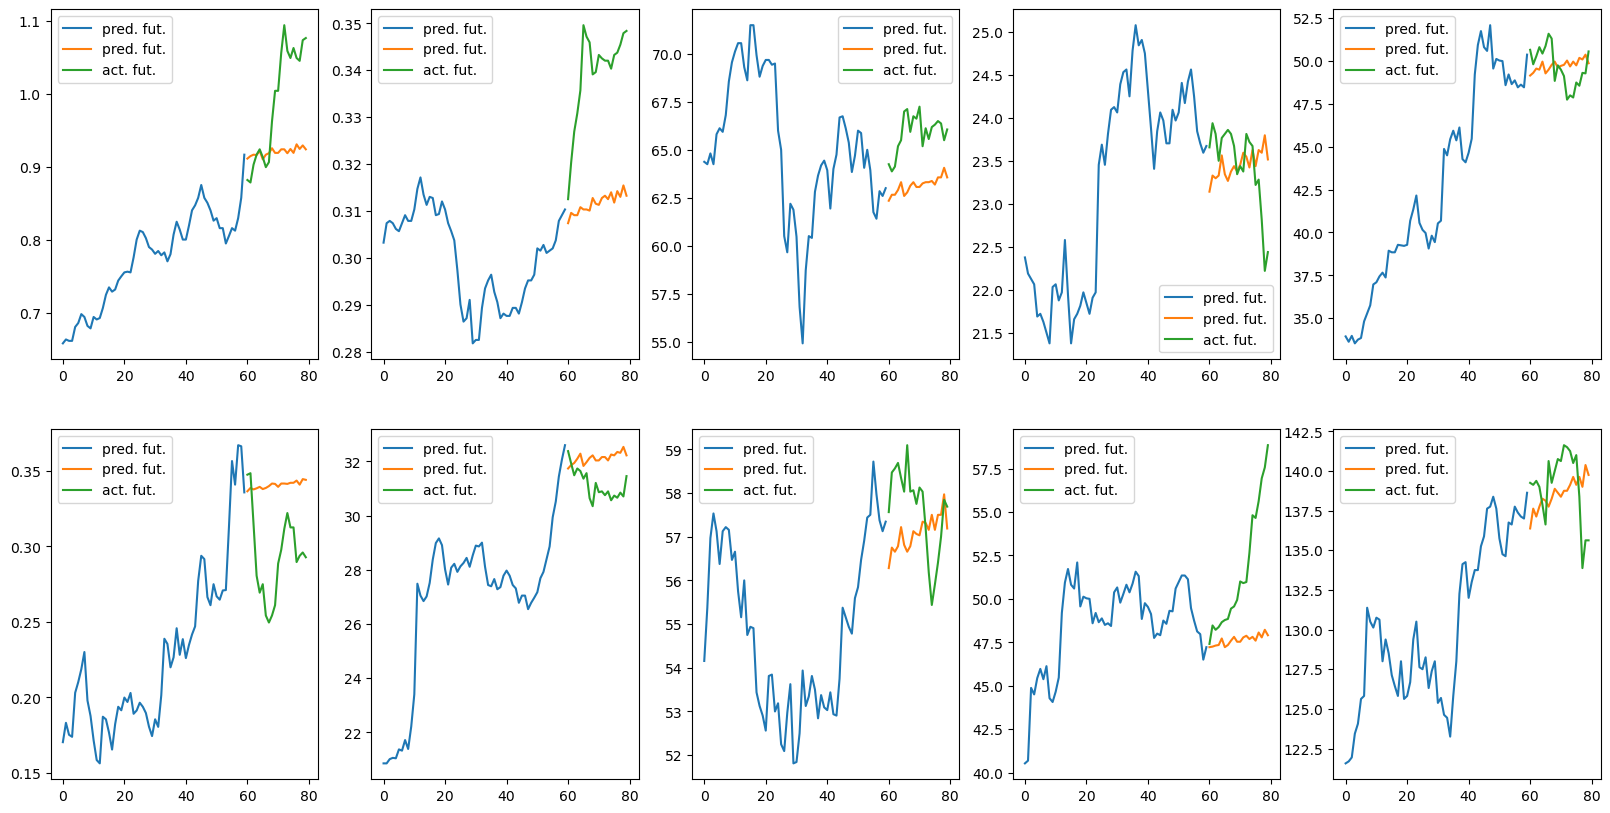

In [24]:
with torch.no_grad():
  std_past, scale_past, dt_past, std_fut, scale_fut, dt_fut, _ = next(iter(test_dl))
  
  X = torch.concat((std_past[:10], dt_past[:10]), dim=2).to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)
  Y = std_fut[:10].reshape((-1, T_FUT)).to(device=DEVICE, dtype=STOCK_PRICE_DTYPE_TORCH)
  Y_hat = model(X)
  
  torch.mean(torch.abs(Y-Y_hat))
  
  fig, ax = plt.subplots(2, 5, figsize=(20, 10))

  for i in range(10):
      ax[i//5, i%5].plot(range(T_PAST), std_past[i, 0, :]*scale_past.numpy()[i, 0, :], label='pred. fut.')
      ax[i//5, i%5].plot(range(T_PAST, T_PAST+T_FUT), Y_hat.cpu().numpy()[i, :]*scale_fut[i, 0, :].cpu().numpy(), label='pred. fut.')
      ax[i//5, i%5].plot(range(T_PAST, T_PAST+T_FUT), Y.cpu().numpy()[i, :]*scale_fut[i, 0, :].cpu().numpy(), label='act. fut.')
      ax[i//5, i%5].legend()

## CNN
**NOT YET TESTED**  
1D Convolutional model

In [ ]:
model = nn.Sequential(
  #
  nn.Conv1d(in_channels=1, out_channels=1, kernel_size=10),
  nn.Linear(120, 80),
  nn.ReLU(),
  nn.Linear(80, 40),
  nn.ReLU(),
  nn.Linear(40, 20)
)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())  # Adam optimizer

num_epochs = 1000
epochs = list(range(num_epochs))
train_losses, test_losses, train_maes, test_maes = [], [], [], []

# Train the model
for epoch in epochs:
    optimizer.zero_grad()  # Zero the gradients
    train_outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(train_outputs, y_train_tensor)  # Calculate the loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    # Evaluate the model
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        train_loss = criterion(train_outputs, y_train_tensor)
        train_losses.append(train_loss)
        train_mae = torch.mean(torch.abs(train_outputs - y_train_tensor))
        train_maes.append(train_mae)

        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss)

        test_mae = torch.mean(torch.abs(test_outputs - y_test_tensor))
        test_maes.append(test_mae)

        

print("Train Loss:", train_loss.item())
print("Test Loss:", test_loss.item())
print("Train MAE:", train_mae.item())
print("Test MAE:", test_mae.item())